In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [9x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe] and
        the second axis is the errors in the first
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.salfeh = self.salariscorrectedfeh(abund)[0] # Salaris Corrected [Fe/H]
        self.salfeh_err = self.salariscorrectedfeh(abund)[1] # Salaris Corrected [Fe/H] Error
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
#         self.wang = {'abpak':/0.078,'arpak':/0.078,'ajak':/0.078,'ahak':/0.078,'akak':1.0}
    
    def salariscorrectedfeh(self,abund):
        '''
        Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
        Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
        # hydrogen_wgt = 1.008 #IUPAC
        # atomic_wgts = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
        # asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
        # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
        # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
        # b = 1-a # b = 0.21036372868803943
        
        Inputs:
        ------
            feh: metallcity of a star
            cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
        Output:
        ------
            salfeh: Salaris corrected metallicity
        '''
        
        # Set things up
        nsamples = 1000
        asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        feh = abund[0,0]
        feh_err = abund[0,1]
        cnalpha = abund[1:,0]
        cnalpha_err = abund[1:,1]
        
        salfehdist = 999999.0*np.ones(nsamples)
        
        for i in range(nsamples):
        
            # Assign solar value to stars if abundance is bad
            for j in range(len(cnalpha)):
                if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
                    cnalpha[j] = 0.0
                if cnalpha_err[j] < -100. or cnalpha_err[j] > 10. or np.isfinite(cnalpha_err[j])==False:
                    cnalpha_err[j] = 0.0

            if np.isfinite(feh) == False:
                feh = 0.0
                feh_err = 0.0

            # Create distribution for the different abundances
            feh_new = np.random.normal(feh,feh_err)
            cnalpha_new = 999999.0*np.ones(len(cnalpha))
            for k in range(len(cnalpha)):
                cnalpha_new[k] = np.random.normal(cnalpha[k],cnalpha_err[k])
            
            # Calculate enhancement factor and corrected metallicity
            fac_acn = sum(10**(asplund+cnalpha_new))/sum(10**asplund)
            salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
            
            salfehdist[i] = salfeh
        
        # Calculate the value and error from the distribution
        calc_salfeh = np.nanmedian(salfehdist)
        calc_salfeh_err = self.mad(salfehdist)
        
        return calc_salfeh, calc_salfeh_err 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
    def teff_2_appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                          bounds=((0.,0.),(14.,2.)),method='trf',sigma=self.phot_err,
                                          absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
#     def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
#         Inputs:
#         ------
#             best_fit_params: [array]
#             lit_age: [float] optional known literature age in Gyr
#             filename: [str] optional filename of plot if saving
#         '''
        
#         # initialize arrays
#         ages = np.arange(0,15,0.25)
#         theos = 999999.0*np.ones((len(ages),5))
#         theos_noext = 999999.0*np.ones((len(ages),5))
    
#         # calculate theoretical age for given ages
#         for j in range(len(ages)):
#             theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
#             theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for i in range(5):
#             ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
#             ax[i].plot(theos[:,i],ages)
            
#             ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
#             ax[i].plot(theos_noext[:,i],ages)
            
#             ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age!=None:
#                 ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
#             ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
#             ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
#             ax[i].set_ylim(bottom=0.01)
            
#             ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
#             ax[i].set_xlabel(r'Magnitude')
            
#         ax[0].legend()

#         ax[0].set_ylabel('Age')
        
#         if star_name!=None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
#                                                                           best_fit_params[1],self.distance))
        
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
#                                                                       self.distance))
    
#         if filename!=None:
#             plt.savefig(filename,bbox_inches='tight')
#         plt.show()
        
    def get_ak(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,nsamples))[ind]
        
        akdist = 999999.0*np.ones(nsamples)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                akdist[j] = calc_ak

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)   
                    akdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
                    if verbose:
                        print('interp',age_spl_interp)
                        print('logteff',lgteffdist[j])
                        print('interp age',age_spl_interp(lgteffdist[j]))
                        print('color',self.phot[i]-self.phot[4])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))
                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 print(calc_ak)
                akdist[j] = calc_ak
            
#         print(akdist)
        med_calc_ak = np.nanmedian(akdist)
        mad_calc_ak = self.mad(akdist)
        
        if np.isfinite(med_calc_ak)==False:
            med_calc_ak = 999999.0
        if np.isfinite(mad_calc_ak)==False:
            mad_calc_ak = 999999.0
        
        self.ak = med_calc_ak
        self.ak_err = mad_calc_ak
        
        return np.array([med_calc_ak,mad_calc_ak])

    def teff_2_appmags_age(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,14),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,14.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Apparent Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Apparent Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Apparent Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params
    
    def test(self,x=3.0):
        print('Hello World!')
    
    def age_diagnostic(self,best_fit_age,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age
        
        Inputs:
        ------
            best_fit_age: best fit age in Gyr
            star_name: name of star
            lit_age: known literature age in Gyr
            filename: name of file if saving plot
        '''
        
        # intialize arrays
        ages = np.arange(0,15,0.25)
        theos_w_ext = 999999.0*np.ones((len(ages),5))
        theos_wo_ext = 999999.0*np.ones((len(ages),5))
        
        # Calculate theoretical mags given an age in ages
        for i in range(len(ages)):
            theos_w_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],self.ak)
            theos_wo_ext[i,:] = self.teff_2_appmags(self.teff,ages[i],0)
            
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for j in range(5):
            # with extinction
            ax[j].scatter(theos_w_ext[:,j],ages,s=100,label='Best Fit Ak')
            ax[j].plot(theos_w_ext[:,j],ages)
            
            # without extinction
            ax[j].scatter(theos_wo_ext[:,j],ages,s=100,label='No Ak')
            ax[j].plot(theos_wo_ext[:,j],ages)
            
            ax[j].axhline(best_fit_age,c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age != None:
                ax[j].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
                
            ax[j].axvline(self.phot[j],ls='--',c='magenta',lw=3.0)
            
#             ax[j].set_xlim(self.phot[j]-3.0,self.phot[j]+3.0)
            ax[j].set_xlim(-14,14)
            ax[j].set_ylim(bottom=0.01)
            
            ax[j].set_title(r'{}: {:.3f}'.format(self.labels[j],self.phot[j]))
            ax[j].set_xlabel(r'Magnitude')
        
        ax[0].legend()
        
        ax[0].set_ylabel('Age')
        
        if star_name != None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_age,
                                                                          self.ak,self.distance))
            
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_age,self.ak,
                                                                      self.distance))
            
        if filename != None:
            plt.savefig(filename,bbox_inches='tight')
            
        plt.show()

In [3]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table, Column

#Numpy/Scipy
import numpy as np

class SynthPop():
    '''    
    A class to create a single mono-age mono-[Fe/H]-ish population of synthetic stars using PARSEC isochrones
    '''
    def __init__(self,age,feh,spec_dispersion,phot_dispersion,ak,distance,isochrones,nstars=100,rv=3.1):
        
        '''
        age: [float] desired age of the synthetic population in Gyr
        feh: [float] desired metalllicity of the synthetic population
        spec_dispersion: [array] dispersion in Teff, [Fe/H], and Log(g) (i.e., array([Teff,[Fe/H],Log(g)]))
        phot_dispersion: [array] dispersion in Gaia and 2MASS bands (i.e., array([GBP,G,GRP,J,H,K]))
        ak: [float] K band extinction
        distance: [float] distance to population in pc
        isochrones: [astropy Table] PARSEC isochrone table
        nstars: [int] number of stars 
        rv: [float] Rv value (=Av/E(B_V))
        '''
        self.nstars = nstars
        
        # Age
        self.age = age 
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],feh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx) 
        
        # Spectroscopy
        self.feh = feh 
        self.spec_disp = spec_dispersion
        
        # Photometry
        self.phot_disp = phot_dispersion
        self.distmod = 5.0*np.log10(distance)-5.0
        self.rv = rv
        
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        self.ak = ak
        
        self.labels = ['Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A_lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A_lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav
    
    def make_pop(self):
        '''
        Create a table of spectroscopic and photomteric values for the sythetic population
        
        Output:
        ------
            poptable: Astropy table of spectroscopic and photometric values for the synthetic population
        '''
        
        ### Prepare isochrone
        
        ### have lie anywhere on isochrone and use initial mass function int_IMF can use to find where fall on isochrones
        
        iso_ = self.iso[np.where(self.iso['logAge']==self.closest(self.iso['logAge'],np.log10(self.age*10**9)))]
        ind = np.floor(np.random.random(self.nstars)*(self.nstars-1)).astype(int)
        ind = np.floor(ind/self.nstars*len(iso_)).astype(int)
        
        ### Calculate extinctions
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        agak = self.ccm_alav(self.leff['Gmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        ### Synthetic Spectroscopy
        synteff = np.random.normal(10**iso_['logTe'][ind],self.spec_disp[0],len(ind))
        synfeh = np.random.normal(iso_['MH'][0],self.spec_disp[1],len(ind))
        synlogg = np.random.normal(iso_['logg'][ind],self.spec_disp[2],len(ind))
        
        ### Synthetic Photometry
        synbp = 999999.0*np.ones(self.nstars)
        syng = 999999.0*np.ones(self.nstars)
        synrp = 999999.0*np.ones(self.nstars) 
        synj = 999999.0*np.ones(self.nstars)
        synh = 999999.0*np.ones(self.nstars) 
        synk = 999999.0*np.ones(self.nstars)
        
        for i in range(self.nstars):
            
            bpmag = (np.random.normal(iso_['G_BPmag'][ind[i]]+self.distmod,self.phot_disp[0]))
            gmag = (np.random.normal(iso_['Gmag'][ind[i]]+self.distmod,self.phot_disp[1]))
            rpmag = (np.random.normal(iso_['G_RPmag'][ind[i]]+self.distmod,self.phot_disp[2]))
            jmag = (np.random.normal(iso_['Jmag'][ind[i]]+self.distmod,self.phot_disp[3]))
            hmag = (np.random.normal(iso_['Hmag'][ind[i]]+self.distmod,self.phot_disp[4]))
            kmag = (np.random.normal(iso_['Ksmag'][ind[i]]+self.distmod,self.phot_disp[5]))

            # BP magnitudes
            if np.isfinite(bpmag)==True:
                synbp[i] = bpmag+self.ak*abpak
            else:
                synbp[i] = 999999.0
                
            # G magnitudes
            if np.isfinite(gmag)==True:
                syng[i] = gmag+self.ak*agak
            else:
                syng[i] = 999999.0
                
            # RP magnitudes
            if np.isfinite(rpmag)==True:
                synrp[i] = rpmag+self.ak*arpak
            else:
                synrp[i] = 999999.0
                
            # J magnitudes
            if np.isfinite(jmag)==True:
                synj[i] = jmag+self.ak*ajak
            else:
                synj[i] = 999999.0
                
            # H magnitudes
            if np.isfinite(hmag)==True:
                synh[i] = hmag+self.ak*ahak
            else:
                synhext[i] = 999999.0
                
            # K magnitudes
            if np.isfinite(kmag)==True:
                synk[i] = kmag+self.ak
            else:
                synk[i] = 999999.0
                
        ages = Column(iso_['logAge'][0]*np.ones(self.nstars),name='LOGAGE',dtype='f8')
        synteff = Column(synteff,name='SYNTHETIC_TEFF',dtype='f8')
        synfeh = Column(synfeh,name='SYNTHETIC_FEH',dtype='f8')
        synlogg = Column(synlogg,name='SYNTHETIC_LOGG',dtype='f8')
        synbp = Column(synbp,name='SYNTHETIC_BP',dtype='f8')
        syng = Column(syng,name='SYNTHETIC_G',dtype='f8')
        synrp = Column(synrp,name='SYNTHETIC_RP',dtype='f8')
        synj = Column(synj,name='SYNTHETIC_J',dtype='f8')
        synh = Column(synh,name='SYNTHETIC_H',dtype='f8')
        synk = Column(synk,name='SYNTHETIC_K',dtype='f8')
        poptable = Table((ages,synteff,synfeh,synlogg,synbp,syng,synrp,synj,synh,synk))
        
        return poptable

In [4]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [36]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_3_5.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
# massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']#,'label']

In [6]:
massive.columns

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','period2','period3','period4','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag','Jmag','Hmag','Ksmag','index')>

In [38]:
max(massive['logAge'])

10.23045

In [39]:
1>=5

False

In [41]:
10**max(massive['logAge'])/10**9

17.000042221563632

In [42]:
10**min(massive['logAge'])/10**9

0.02499999950079735

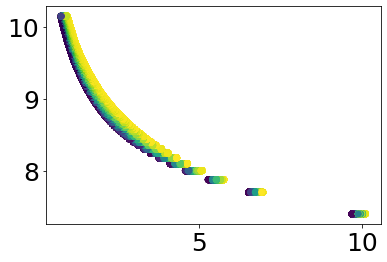

In [8]:
plt.scatter(massive['Mini'],massive['logAge'],c=massive['MH'])

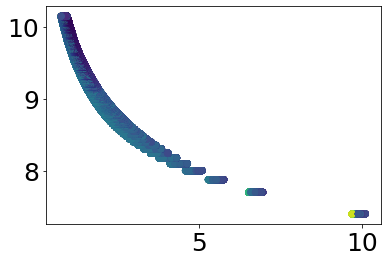

In [9]:
plt.scatter(massive['Mini'],massive['logAge'],c=massive['logTe'])

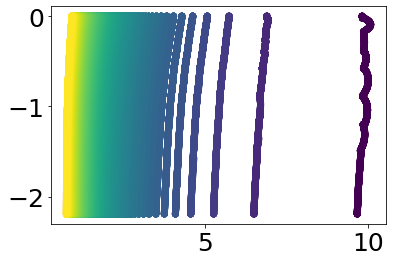

In [10]:
plt.scatter(massive['Mini'],massive['MH'],c=massive['logAge'])

In [11]:
len(np.unique(massive['index']))

7403130

# Gaia Errors

In [12]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

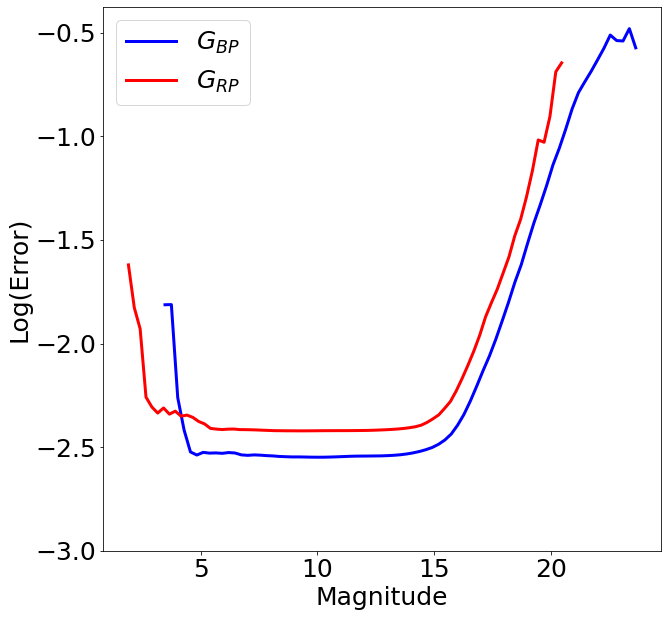

In [13]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

# bperr = 10**bperrfunc(kascdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
# rperr = 10**rperrfunc(kascdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

In [14]:
test = SynthPop(12.5,-2.0,np.array([10,0.008064152,0.024365166]),
                np.array([0.0028720951748863748,0.0038024856988601117,0.021,0.02,0.025,0.017]),
                0.017,5000,massive,nstars=1000)
testpop = test.make_pop()
testpop

LOGAGE,SYNTHETIC_TEFF,SYNTHETIC_FEH,SYNTHETIC_LOGG,SYNTHETIC_BP,SYNTHETIC_G,SYNTHETIC_RP,SYNTHETIC_J,SYNTHETIC_H,SYNTHETIC_K
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10.096910000000001,5424.345615734922,-2.0003850640427876,3.14224282139533,15.957595551466156,15.597903211181563,15.06449434245254,14.354774460865876,13.992504370718107,13.860401310347
10.096910000000001,5205.129693378752,-2.0079729066099152,2.4552338797926545,14.579450416770275,14.175733809796599,13.595568359376632,12.820064227930125,12.409848974318146,12.300184298452884
10.096910000000001,5390.058105405603,-2.003159144850203,3.004831047441823,15.716079412016926,15.337979365879024,14.824829482184734,14.111894984451741,13.6655701155271,13.608693655851301
10.096910000000001,4581.5175089257355,-2.014304251462524,1.0318986781290902,11.826812561266838,11.209853732319873,10.406889196225015,9.499436824283059,8.901018385897595,8.81087642676925
10.096910000000001,5357.545461235045,-2.0054021238085817,2.8763456481551657,15.480096095670874,15.094957958846448,14.536826058541577,13.820279104322928,13.41812373195396,13.330279160848411
10.096910000000001,4681.486574974048,-1.9968238742751558,1.193077686180895,12.15175132249997,11.591699632052924,10.900349554019408,9.968825930583288,9.368893241703379,9.27577004061014
10.096910000000001,5327.607903546377,-2.003282573399638,2.7990048253404685,15.364308352250958,14.984667245621809,14.387125929389923,13.699813876064848,13.263532894064015,13.207192304643627
10.096910000000001,4570.770857679783,-2.006824944929782,0.9465777488739064,11.75146898668798,11.105530613860955,10.362038159820449,9.401145234371002,8.755983347185461,8.705834750046389
10.096910000000001,5233.057678872848,-2.005896405726652,2.554467751302079,14.79745359547685,14.400136105698502,13.810436340171913,13.079068364046064,12.701207446908885,12.539927112219965


In [17]:
testpop2 = testpop[np.where((testpop['SYNTHETIC_K']<=13.0)&(testpop['SYNTHETIC_K']>=9.0))][::5]

len(testpop2)

125

In [18]:
synak = 999999.0*np.ones((len(testpop2),2))
synage = 999999.0*np.ones((len(testpop2),2))
for i in tqdm_notebook(range(len(testpop2))):
    
    abundance = np.array([[testpop2['SYNTHETIC_FEH'][i],0.,0.,0.,0.,0.,0.,0.,0.],[0.2,0.,0.,0.,0.,0.,0.,0.,0.]]).T
    phots = np.array([[testpop2['SYNTHETIC_BP'][i],testpop2['SYNTHETIC_RP'][i],testpop2['SYNTHETIC_J'][i],
                      testpop2['SYNTHETIC_H'][i],testpop2['SYNTHETIC_K'][i]],[0.025,0.025,0.025,0.025,0.025]]).T
    
    teffs = np.array([testpop2['SYNTHETIC_TEFF'][i],100])
    
    CalcAge = Aetas(teffs,abundance,phots,5000,massive)
    
    # Extinctions
    ak_val, ak_err = CalcAge.get_ak(12.5)
    synak[i,0] = ak_val
    synak[i,1] = ak_err
    
    # Ages
    age_val, age_err = CalcAge.get_age()
    synage[i,0] = age_val
    synage[i,1] = age_err
    

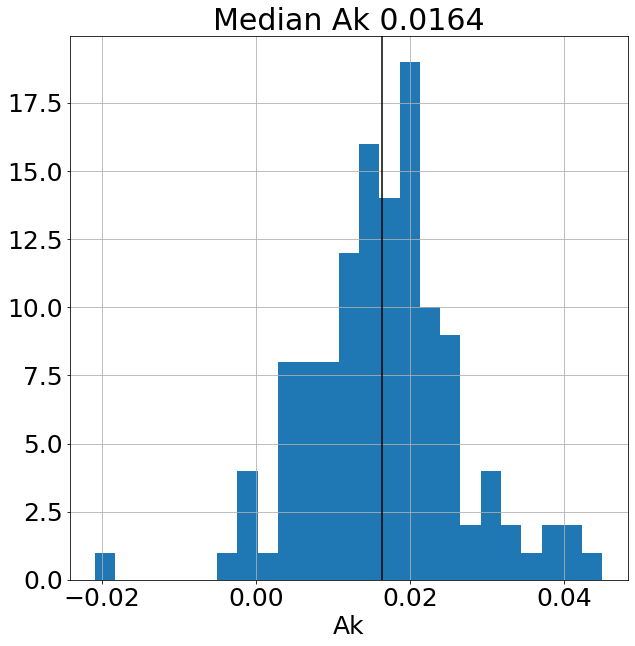

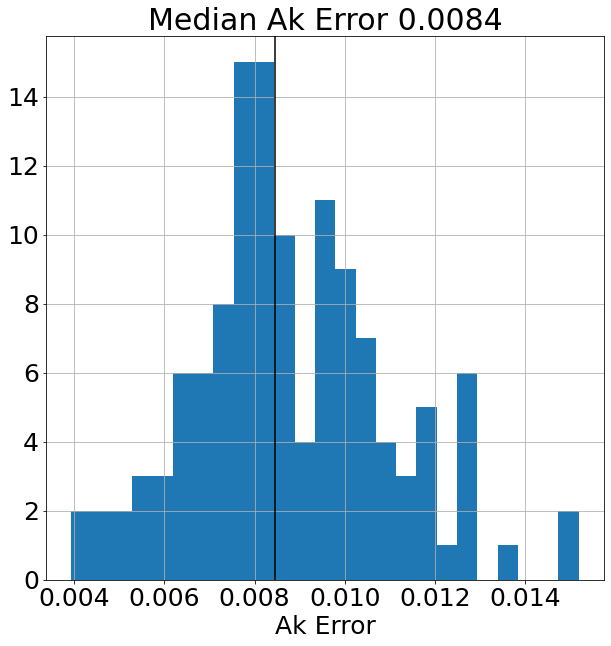

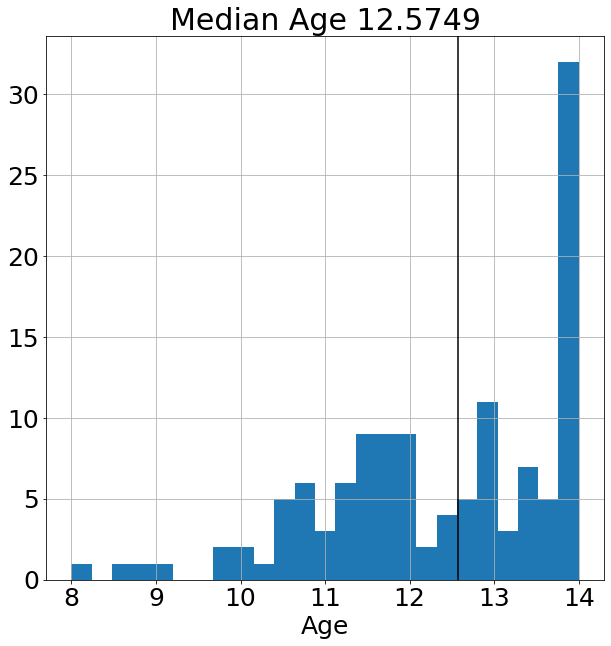

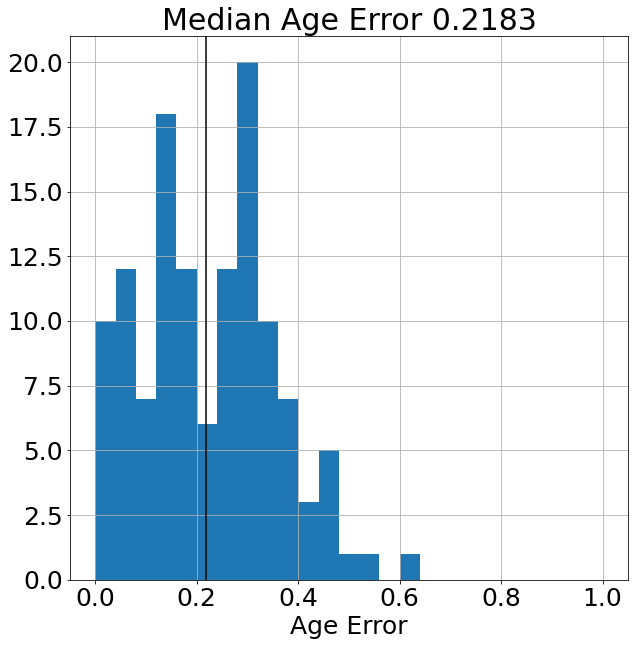

In [19]:
### Ak
plt.figure(figsize=[10,10])
plt.hist(synak[:,0],bins=25)
plt.axvline(np.median(synak[:,0]),c='k')
plt.title('Median Ak {:.4f}'.format(np.median(synak[:,0])))
plt.xlabel(r'Ak')
plt.grid()
plt.show()

plt.figure(figsize=[10,10])
plt.hist(synak[:,1],bins=25)
plt.axvline(np.median(synak[:,1]),c='k')
plt.title('Median Ak Error {:.4f}'.format(np.median(synak[:,1])))
plt.xlabel(r'Ak Error')
plt.grid()
plt.show()

### Age
plt.figure(figsize=[10,10])
plt.hist(synage[:,0],bins=25)
plt.axvline(np.median(synage[:,0]),c='k')
plt.title('Median Age {:.4f}'.format(np.median(synage[:,0])))
plt.xlabel(r'Age')
plt.grid()
plt.show()

plt.figure(figsize=[10,10])
plt.hist(synage[:,1],bins=25,range=(0,1))
plt.axvline(np.median(synage[:,1]),c='k')
plt.title('Median Age Error {:.4f}'.format(np.median(synage[:,1])))
plt.xlabel(r'Age Error')
plt.grid()
plt.show()

In [20]:
len(np.unique(synage[:,0]))

112

In [21]:
len(np.squeeze(np.where(synage[:,0]==max(synage[:,0]))))

14

In [22]:
len(synage[:,0][np.where(synage[:,0]==max(synage[:,0]))])

14

In [23]:
for i in np.unique(synage[:,0]):
    print(i)

7.999908144858229
8.625017761993638
8.774957179057612
9.174977353945446
9.807539083839766
9.892010194284136
9.966598971204109
10.147411355160065
10.249908743997024
10.456174823686986
10.475023284393092
10.48036244505399
10.625025963952792
10.625025964437075
10.65000964073287
10.695988200287255
10.750037989787332
10.756399489626636
10.77494347768054
10.875018391297989
10.899962581338647
11.008573223756633
11.024908671747292
11.124871542140971
11.15000336970286
11.174934854066269
11.200748913950147
11.280812656340673
11.359568836318608
11.39588229084647
11.400003864462615
11.475060845878035
11.507542222214125
11.524975215828
11.570846784146605
11.57223125734546
11.574973359883789
11.574973396466001
11.618575202310359
11.649975236859476
11.675083414551017
11.675083629625625
11.699976824013243
11.749922453164023
11.774975119487332
11.813439836442312
11.824968708419126
11.875037761818888
11.950057627393
11.950057646158239
11.97498563762799
11.99234184322495
11.999965627656216
12.03858267443

In [24]:
print('Number over 13.0 Gyr: ',len(synage[:,0][np.where(synage[:,0]>=13.5)]))
print(synage[:,0][np.where(synage[:,0]>=13.5)])

Number over 13.0 Gyr:  37
[14.         13.97494154 13.94986484 13.55001988 14.         14.
 13.550022   14.         14.         14.         14.         13.84984782
 14.         14.         14.         13.57500506 14.         14.
 13.57500501 14.         13.8785314  13.9749416  13.89984633 13.94986479
 14.         13.97494155 13.67492653 13.97494156 14.         13.89984593
 13.89984637 14.         14.         13.97494155 14.         13.97494158
 14.        ]


In [28]:
ak_ejk = ccm_alav(leff['K'],3.1)/(ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))

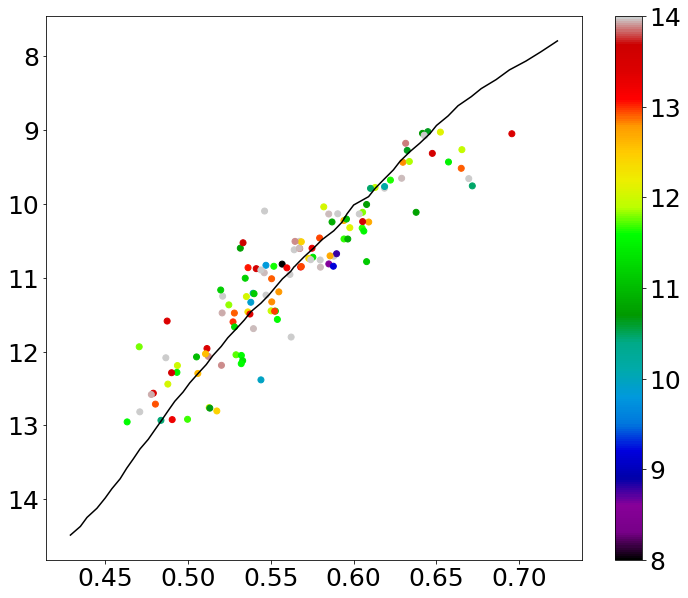

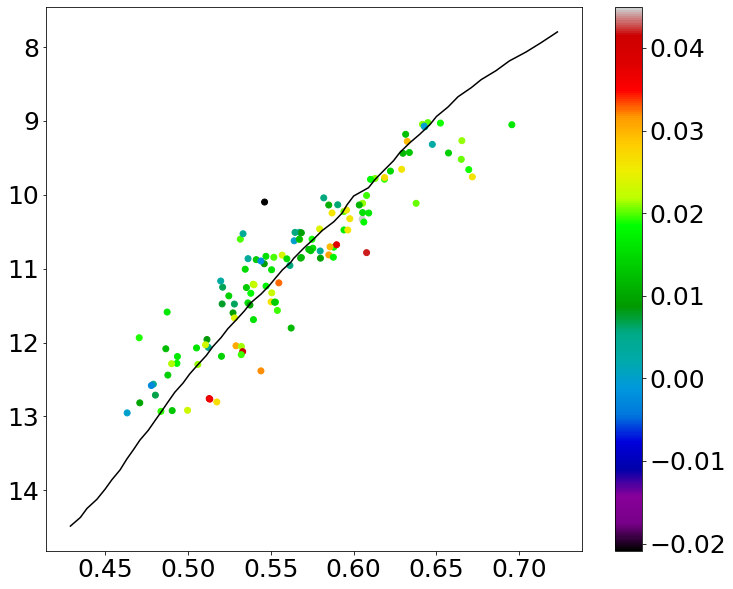

In [29]:
isopick = np.where((massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9)))&(massive['MH']==closest(massive['MH'],-2.0)))
sorte = massive[isopick][np.argsort(massive[isopick]['logTe'])]

plt.figure(figsize=[12,10])
plt.scatter(testpop2['SYNTHETIC_J']-testpop2['SYNTHETIC_K']-synak[:,0]/ak_ejk,
            testpop2['SYNTHETIC_K']-synak[:,0],c=synage[:,0],cmap='nipy_spectral')
plt.colorbar()
plt.plot((sorte['Jmag']-sorte['Ksmag']),sorte['Ksmag']+5.*np.log10(5000)-5.0,c='k')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(testpop2['SYNTHETIC_J']-testpop2['SYNTHETIC_K']-synak[:,0]/ak_ejk,
            testpop2['SYNTHETIC_K']-synak[:,0],c=synak[:,0],cmap='nipy_spectral')
plt.colorbar()
plt.plot((sorte['Jmag']-sorte['Ksmag']),sorte['Ksmag']+5.*np.log10(5000)-5.0,c='k')
plt.gca().invert_yaxis()
plt.show()

Text(0, 0.5, 'True - Calculated Ak')

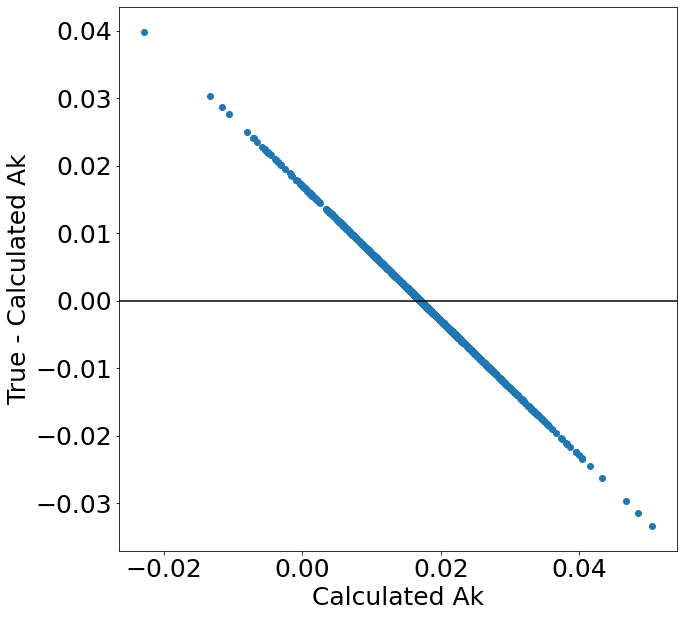

In [114]:
plt.figure(figsize=[10,10])
plt.scatter(synak[:,0],0.017-synak[:,0])
plt.axhline(0,c='k')
plt.xlabel(r'Calculated Ak')
plt.ylabel(r'True - Calculated Ak')

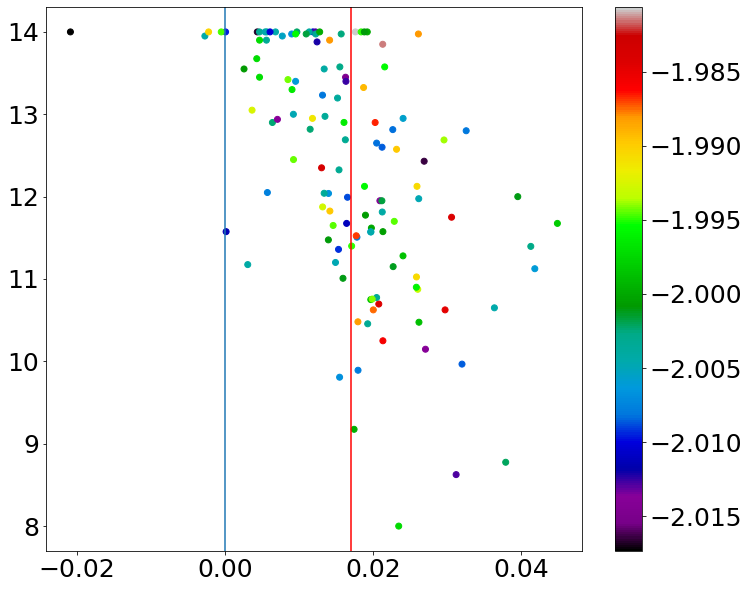

In [31]:
plt.figure(figsize=[12,10])
plt.scatter(synak[:,0],synage[:,0],c=testpop2['SYNTHETIC_FEH'],cmap='nipy_spectral')
plt.axvline(0.017,c='r')
plt.axvline(0.0)
plt.colorbar()

In [137]:
np.where(synak[:,0]<0)

(array([ 69,  99, 122, 187, 197, 293, 301, 314, 354, 414, 442, 466, 482,
        513, 557, 603, 635, 651, 653, 660, 667, 715, 726, 731, 732, 760,
        800, 828, 849, 853, 932, 936, 942, 953, 971, 980]),)

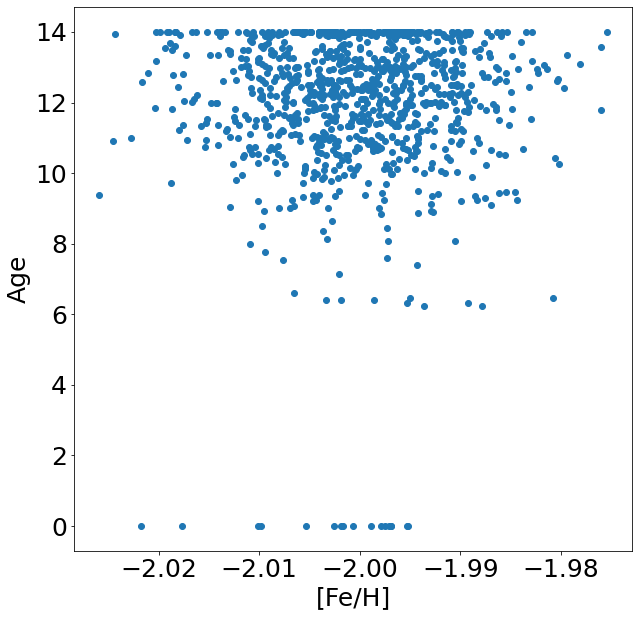

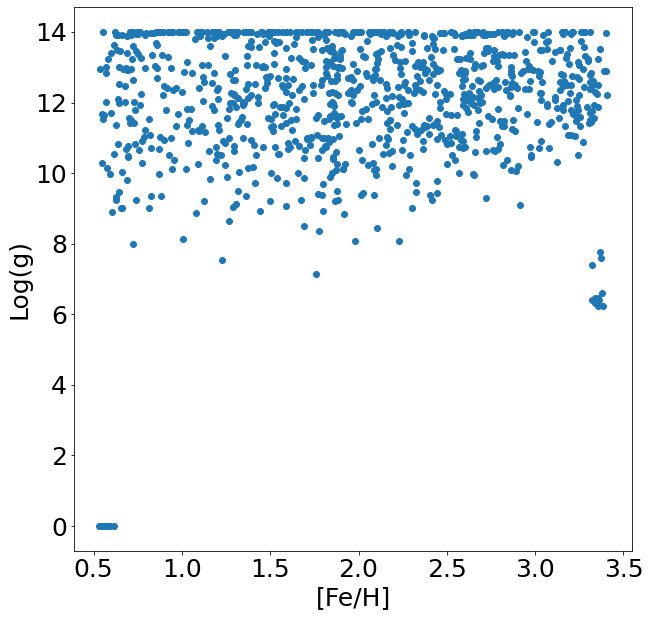

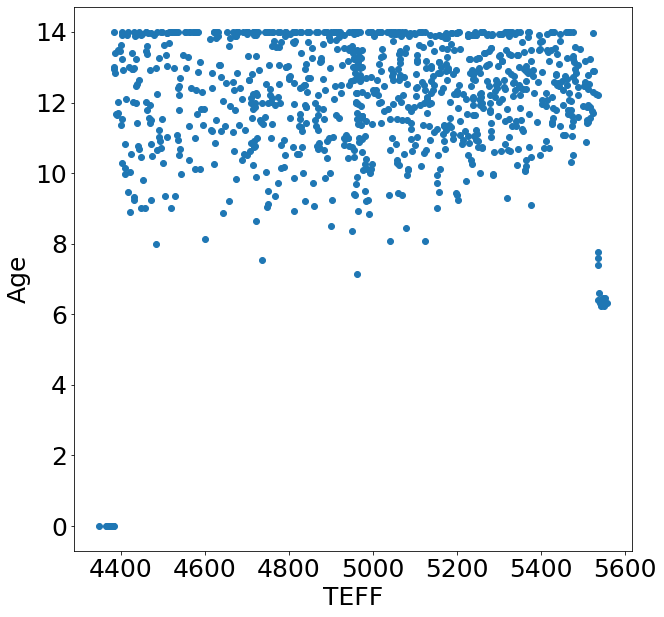

In [122]:
plt.figure(figsize=[10,10])
plt.scatter(testpop['SYNTHETIC_FEH'],synage[:,0])
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Age')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(testpop['SYNTHETIC_LOGG'],synage[:,0])
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Log(g)')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(testpop['SYNTHETIC_TEFF'],synage[:,0])
plt.xlabel(r'TEFF')
plt.ylabel(r'Age')
plt.show()

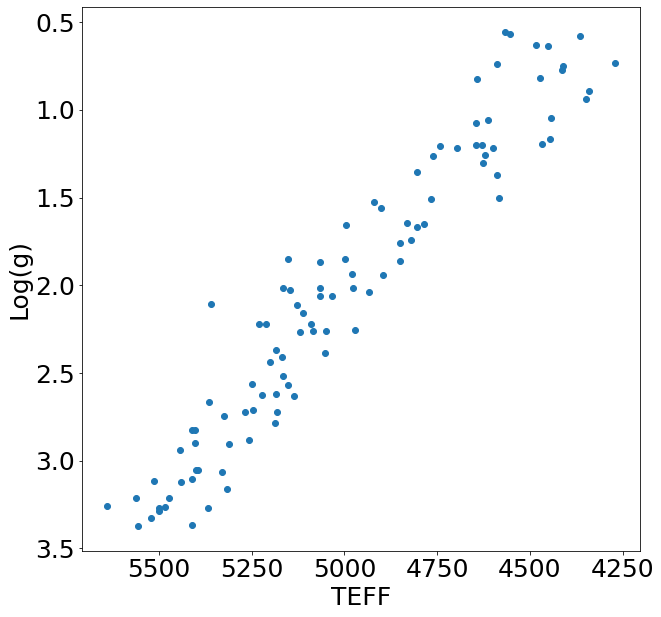

In [96]:
plt.figure(figsize=[10,10])
plt.scatter(testpop['SYNTHETIC_TEFF'],testpop['SYNTHETIC_LOGG'])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel(r'TEFF')
plt.ylabel(r'Log(g)')
plt.show()

In [83]:
harris = fits.getdata('/Users/joshuapovick/Desktop/Research/harris/harris.fits')
harris.columns

ColDefs(
    name = 'ID'; format = '15A'
    name = 'RA'; format = '15A'
    name = 'DEC'; format = '15A'
    name = 'l'; format = 'E'
    name = 'b'; format = 'E'
    name = 'R_sun'; format = 'E'
    name = 'R_gc'; format = 'E'
    name = 'X'; format = 'E'
    name = 'Y'; format = 'E'
    name = 'Z'; format = 'E'
    name = '[Fe/H]'; format = 'E'
    name = 'wt'; format = 'E'
    name = 'E(B-V)'; format = 'E'
    name = 'V_HB'; format = 'E'
    name = '(m-M)V'; format = 'E'
    name = 'V_t'; format = 'E'
    name = 'M_V,t'; format = 'E'
    name = 'U-B'; format = 'E'
    name = 'B-V'; format = 'E'
    name = 'V-R'; format = 'E'
    name = 'V-I'; format = 'E'
    name = 'spt'; format = '10A'
    name = 'ellip'; format = 'E'
    name = 'v_r'; format = 'E'
    name = 'v_r_err'; format = 'E'
    name = 'v_LSR'; format = 'E'
    name = 'sig_v'; format = 'E'
    name = 'sig_v_err'; format = 'E'
    name = 'c'; format = 'E'
    name = 'r_c'; format = 'E'
    name = 'r_h'; format = 'E'
    na

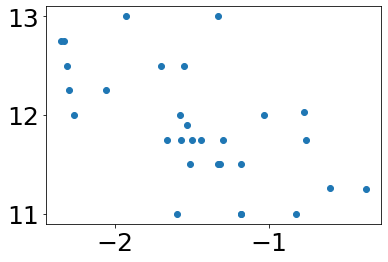

In [84]:
vanden_feh = np.array([-0.76,-1.57,-1.03,-1.33,-1.58,-2.33,-1.53,-1.66,-1.70,-1.50,-1.18,-1.33,-2.06,-1.44,-1.93,
                       -2.27,-0.82,-1.60,-2.35,-1.18,-1.18,-1.32,-1.51,-1.30,-2.30,-2.31,-0.37,-0.77,-1.55,-0.60])
vanden_age = np.array([11.75,11.75,12.00,13.00,12.00,12.75,11.90,11.75,12.50,11.75,11.50,11.50,12.25,11.75,13.00,
                       12.00,11.00,11.0,12.75,11.00,11.00,11.50,11.50,11.75,12.25,12.50,11.25,12.03,12.50,11.26])

plt.scatter(vanden_feh,vanden_age)

In [140]:
# testpop2
test2 = SynthPop(11.0,-1.5,np.array([10,0.008064152,0.024365166]),
                np.array([0.0028720951748863748,0.0038024856988601117,0.021,0.02,0.025,0.017]),
                0.04,5000,massive,nstars=1000)
testpop2 = test2.make_pop()
testpop2

LOGAGE,SYNTHETIC_TEFF,SYNTHETIC_FEH,SYNTHETIC_LOGG,SYNTHETIC_BP,SYNTHETIC_G,SYNTHETIC_RP,SYNTHETIC_J,SYNTHETIC_H,SYNTHETIC_K
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10.04139,4163.8138194242665,-1.4951900675074012,0.5565570117891694,11.669477859615142,10.820384971039545,9.888866414705229,8.677487212249584,7.910868252014353,7.773648325445097
10.04139,5132.418788120279,-1.5015921592247683,2.4483709093997126,14.77042910272602,14.310665425603672,13.689042793564662,12.847662784836032,12.36253855331218,12.272395757607736
10.04139,5348.709835515627,-1.4937544773878326,2.9968770879224484,15.986775357569712,15.56429887540726,14.954475945416178,14.182558059028615,13.749634845798496,13.675560149061665
10.04139,4521.652667328615,-1.500806772274064,1.1651595818000902,12.52807761387877,11.877059361193878,11.10280116199233,10.026493940080906,9.395081374022379,9.303020038902057
10.04139,4547.561748956067,-1.4936436180458224,1.2499363772058765,12.616401047938126,11.967930959211253,11.194131012891928,10.183658596086374,9.571169385615166,9.434466371565541
10.04139,5091.08326096024,-1.5023696012149503,2.344542412952853,14.565861864235485,14.097735777551117,13.476541375957396,12.631448116837307,12.115521252804184,11.994141945150208
10.04139,5249.09383967116,-1.4906056462100044,2.799519498467258,15.40007769632858,14.974293814098226,14.316339027101371,13.572617088263176,13.124944735027654,13.01340828816168
10.04139,4661.121757274467,-1.4875704274539818,1.4008300026901706,12.941772160802445,12.353312813000395,11.667616561173304,10.646720844457574,10.057700005310782,9.877316856006248
10.04139,5278.473582830075,-1.4974236108954513,2.8576476736766474,15.62786293964945,15.20063833837629,14.58761538198652,13.851203988552983,13.345340788813784,13.273135774169013


In [141]:
synak2 = 999999.0*np.ones((len(testpop2),2))
synage2 = 999999.0*np.ones((len(testpop2),2))
for i in tqdm_notebook(range(len(testpop2))):
    
    abundance = np.array([[testpop2['SYNTHETIC_FEH'][i],0.,0.,0.,0.,0.,0.,0.,0.],[0.2,0.,0.,0.,0.,0.,0.,0.,0.]]).T
    phots = np.array([[testpop2['SYNTHETIC_BP'][i],testpop2['SYNTHETIC_RP'][i],testpop2['SYNTHETIC_J'][i],
                      testpop2['SYNTHETIC_H'][i],testpop2['SYNTHETIC_K'][i]],[0.025,0.025,0.025,0.025,0.025]]).T
    
    teffs = np.array([testpop2['SYNTHETIC_TEFF'][i],100])
    
    CalcAge = Aetas(teffs,abundance,phots,5000,massive)
    
    # Extinctions
    ak_val, ak_err = CalcAge.get_ak(12.5)
    synak2[i,0] = ak_val
    synak2[i,1] = ak_err
    
    # Ages
    age_val, age_err = CalcAge.get_age()
    synage2[i,0] = age_val
    synage2[i,1] = age_err

Text(0, 0.5, 'True - Calculated Ak')

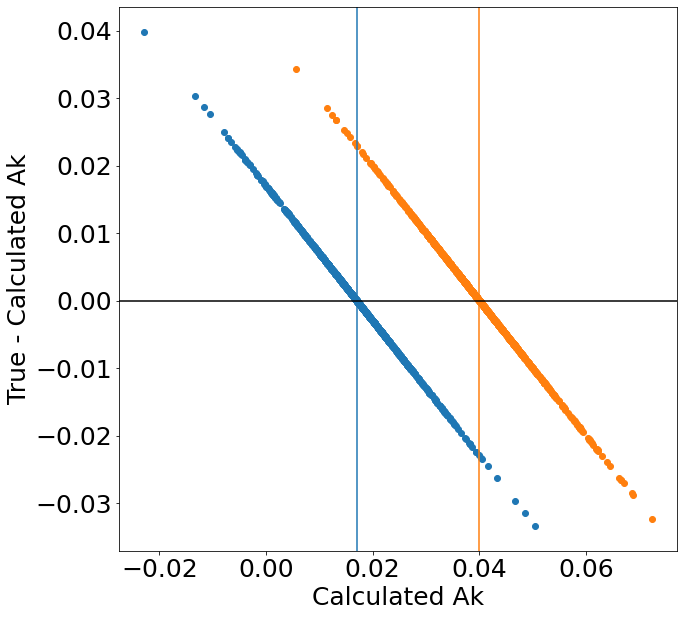

In [145]:
plt.figure(figsize=[10,10])
plt.scatter(synak[:,0],0.017-synak[:,0])
plt.axvline(0.017,c='tab:blue')
plt.scatter(synak2[:,0],0.04-synak2[:,0])
plt.axvline(0.04,c='tab:orange')
plt.axhline(0,c='k')
plt.xlabel(r'Calculated Ak')
plt.ylabel(r'True - Calculated Ak')

In [150]:
z = np.polyfit(synak[:,0],0.017-synak[:,0],1)
z2 = np.polyfit(synak2[:,0],0.04-synak2[:,0],1)

print(np.poly1d(z))
print(np.poly1d(z2))

 
-1 x + 0.017
 
-1 x + 0.04


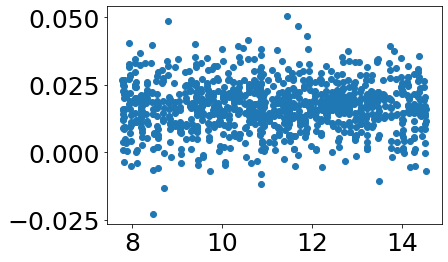

In [157]:
plt.scatter(testpop['SYNTHETIC_K'],synak[:,0])

In [154]:
mad(synak[:,0])

0.005407006683489361

In [158]:
mad(testpop['SYNTHETIC_K'])

1.5747191811574295

In [159]:
mad(testpop2['SYNTHETIC_K'])

1.6055022560193226

In [162]:
# testpop3
test3 = SynthPop(11.0,-1.5,np.array([10,0.008064152,0.024365166]),np.array([0.001,0.001,0.001,0.001,0.001,0.001]),
                0.04,5000,massive,nstars=100)
testpop3 = test3.make_pop()
testpop3

LOGAGE,SYNTHETIC_TEFF,SYNTHETIC_FEH,SYNTHETIC_LOGG,SYNTHETIC_BP,SYNTHETIC_G,SYNTHETIC_RP,SYNTHETIC_J,SYNTHETIC_H,SYNTHETIC_K
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10.04139,4217.2638026183,-1.4937016428621297,0.6371122773318532,11.794459163055457,10.979721117899736,10.096437703587448,8.891292034934906,8.155362772014467,8.017635912297605
10.04139,5461.617808978948,-1.4923531191115282,3.357661833635421,16.66723542324592,16.265953836456475,15.68759984549309,14.940390055918291,14.529995307266354,14.442489427567644
10.04139,5337.17839504794,-1.494782520321379,3.036551517340542,15.979451882440046,15.561495125613453,14.967973058046962,14.185624260544854,13.751941985814847,13.657934358954925
10.04139,5319.969068509378,-1.5076928617194154,2.976331104444656,15.862752540514206,15.442607763888494,14.844977713985863,14.058997201705818,13.61949775896982,13.527129422880199
10.04139,4775.862701425953,-1.4854202311499338,1.691630531582435,13.30830472933592,12.764430187465122,12.060108702109009,11.112326845126537,10.54310227961628,10.4363574029914
10.04139,4959.26975623971,-1.4959525799120845,2.0836420615388733,14.002350813639115,13.512722089156263,12.84684429034921,11.956860956048361,11.43357644308013,11.330414543824547
10.04139,4934.877619007421,-1.4992213345208694,2.002312738542825,13.877109546269066,13.374370596030635,12.70663002767819,11.805140160059015,11.275710573300518,11.170257664538681
10.04139,4965.4883057419165,-1.4929679299788934,2.0867705813746147,14.005992718092143,13.51025669740842,12.848142245648297,11.956122666686152,11.43445493900923,11.330523550305774
10.04139,4473.573982291236,-1.4910585834095014,1.0875315033845556,12.36312359318343,11.67978958105175,10.879410996259532,9.805523784684993,9.15008510902305,9.033715929324115


In [163]:
synak3 = 999999.0*np.ones((len(testpop3),2))
synage3 = 999999.0*np.ones((len(testpop3),2))
for i in tqdm_notebook(range(len(testpop3))):
    
    abundance = np.array([[testpop3['SYNTHETIC_FEH'][i],0.,0.,0.,0.,0.,0.,0.,0.],[0.2,0.,0.,0.,0.,0.,0.,0.,0.]]).T
    phots = np.array([[testpop3['SYNTHETIC_BP'][i],testpop3['SYNTHETIC_RP'][i],testpop3['SYNTHETIC_J'][i],
                      testpop3['SYNTHETIC_H'][i],testpop3['SYNTHETIC_K'][i]],[0.025,0.025,0.025,0.025,0.025]]).T
    
    teffs = np.array([testpop3['SYNTHETIC_TEFF'][i],100])
    
    CalcAge = Aetas(teffs,abundance,phots,5000,massive)
    
    # Extinctions
    ak_val, ak_err = CalcAge.get_ak(12.5)
    synak3[i,0] = ak_val
    synak3[i,1] = ak_err
    
    # Ages
    age_val, age_err = CalcAge.get_age()
    synage3[i,0] = age_val
    synage3[i,1] = age_err

Text(0, 0.5, 'True - Calculated Ak')

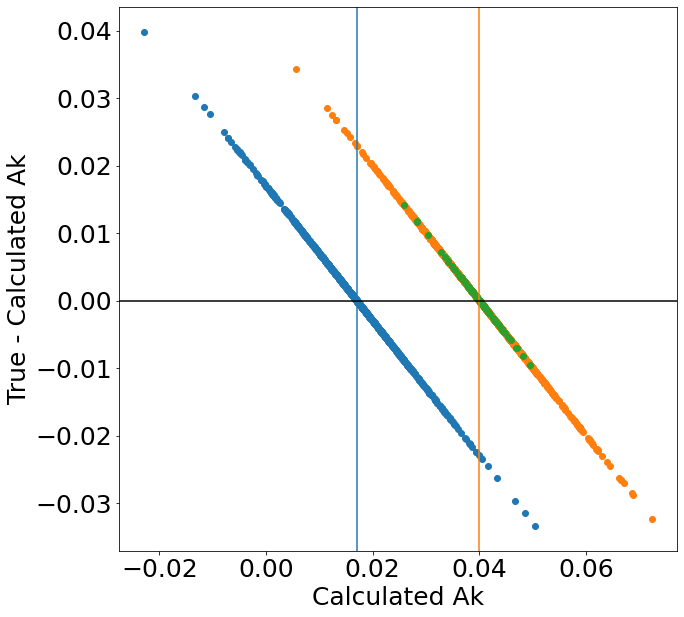

In [164]:
plt.figure(figsize=[10,10])
plt.scatter(synak[:,0],0.017-synak[:,0])
plt.axvline(0.017,c='tab:blue')
plt.scatter(synak2[:,0],0.04-synak2[:,0])
plt.axvline(0.04,c='tab:orange')
plt.scatter(synak3[:,0],0.04-synak3[:,0])
plt.axhline(0,c='k')
plt.xlabel(r'Calculated Ak')
plt.ylabel(r'True - Calculated Ak')

In [165]:
mad(testpop3['SYNTHETIC_K'])

1.7901627406079639

In [167]:
mad(synak3[:,0])

0.0018340123627126337

In [187]:
number = np.array([10,25,50,75,100,125,150,275,200,500])

akmeds = 999999*np.ones(len(number))
akmads = 999999*np.ones(len(number))
agmeds = 999999*np.ones(len(number))
agmads = 999999*np.ones(len(number))

for i in tqdm_notebook(range(len(number))):
    
    spop = SynthPop(11.0,-1.5,np.array([10,0.01,0.01]),np.array([0.001,0.001,0.001,0.001,0.001,0.001]),
                0.04,5000,massive,nstars=number[i])
    spoptab = spop.make_pop()
    
    spopak = 999999.0*np.ones((len(spoptab),2))
    spopage = 999999.0*np.ones((len(spoptab),2))
    for j in tqdm_notebook(range(len(spoptab)),leave=False):

        abundance = np.array([[spoptab['SYNTHETIC_FEH'][j],0.,0.,0.,0.,0.,0.,0.,0.],[0.2,0.,0.,0.,0.,0.,0.,0.,0.]]).T
        phots = np.array([[spoptab['SYNTHETIC_BP'][j],spoptab['SYNTHETIC_RP'][j],spoptab['SYNTHETIC_J'][j],
                          spoptab['SYNTHETIC_H'][j],spoptab['SYNTHETIC_K'][j]],[0.025,0.025,0.025,0.025,0.025]]).T

        teffs = np.array([spoptab['SYNTHETIC_TEFF'][j],100])

        CalcAge = Aetas(teffs,abundance,phots,5000,massive)

        # Extinctions
        spopak[j,0] = CalcAge.get_ak(12.5)[0]
        spopak[j,1] = CalcAge.get_ak(12.5)[1]
        
        # Ages
        spopage[j,0] = CalcAge.get_age()[0]
        spopage[j,1] = CalcAge.get_age()[1]
    
    akmeds[i] = np.median(spopak[:,0])
    akmads[i] = mad(spopak[:,1])
    agmeds[i] = np.median(spopage[:,0])
    agmads[i] = mad(spopage[:,1]) 

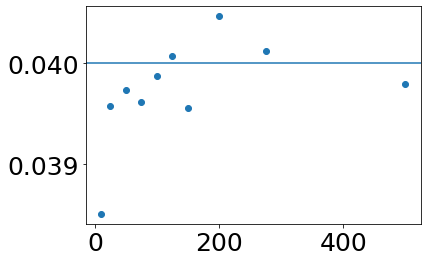

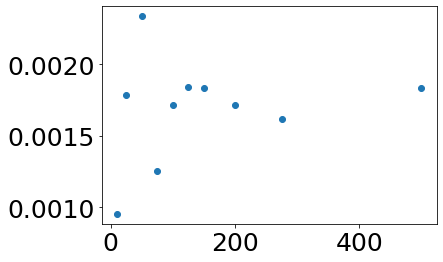

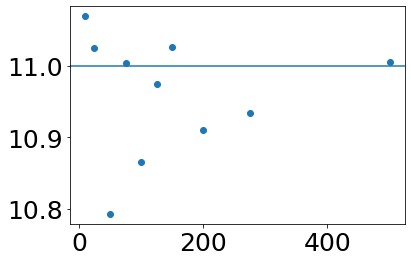

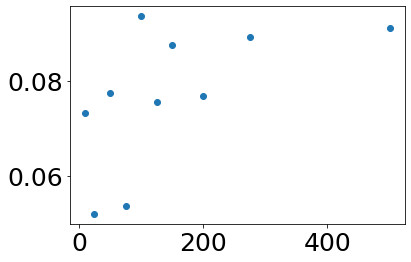

In [207]:
plt.scatter(number,akmeds)
plt.axhline(0.04)
plt.show()
plt.scatter(number,akmads)
plt.show()
plt.scatter(number,agmeds)
plt.axhline(11.0)
plt.show()
plt.scatter(number,agmads)
plt.show()

In [191]:
magdisp = np.array([0.0,0.0005,0.001,0.0025,0.005,0.01])

akmeds_mag = 999999*np.ones(len(magdisp))
akmads_mag = 999999*np.ones(len(magdisp))
agmeds_mag = 999999*np.ones(len(magdisp))
agmads_mag = 999999*np.ones(len(magdisp))

for i in tqdm_notebook(range(len(magdisp))):
    
    spop = SynthPop(11.0,-1.5,np.array([10,0.01,0.01]),magdisp[i]*np.ones(6),
                0.04,5000,massive,nstars=275)
    spoptab = spop.make_pop()
    
    spopak = 999999.0*np.ones((len(spoptab),2))
    for j in tqdm_notebook(range(len(spoptab)),leave=False):

        abundance = np.array([[spoptab['SYNTHETIC_FEH'][j],0.,0.,0.,0.,0.,0.,0.,0.],[0.2,0.,0.,0.,0.,0.,0.,0.,0.]]).T
        phots = np.array([[spoptab['SYNTHETIC_BP'][j],spoptab['SYNTHETIC_RP'][j],spoptab['SYNTHETIC_J'][j],
                          spoptab['SYNTHETIC_H'][j],spoptab['SYNTHETIC_K'][j]],[0.025,0.025,0.025,0.025,0.025]]).T

        teffs = np.array([spoptab['SYNTHETIC_TEFF'][j],100])

        CalcAge = Aetas(teffs,abundance,phots,5000,massive)

        # Extinctions
        spopak[j,0] = CalcAge.get_ak(12.5)[0]
        spopak[j,1] = CalcAge.get_ak(12.5)[1]
        
        # Ages
        spopage[j,0] = CalcAge.get_age()[0]
        spopage[j,1] = CalcAge.get_age()[1]
    
    akmeds_mag[i] = np.median(spopak[:,0])
    akmads_mag[i] = mad(spopak[:,1])
    agmeds_mag[i] = np.median(spopage[:,0])
    agmads_mag[i] = mad(spopage[:,1])

In [197]:
print(len(akmeds_mag))
print(len(magdisp))

10
6


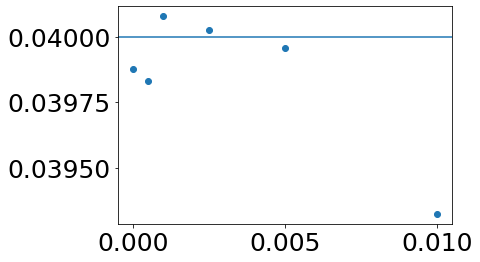

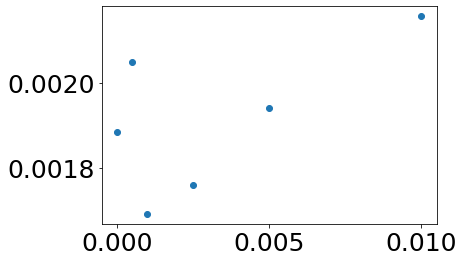

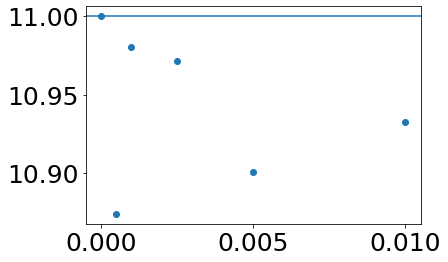

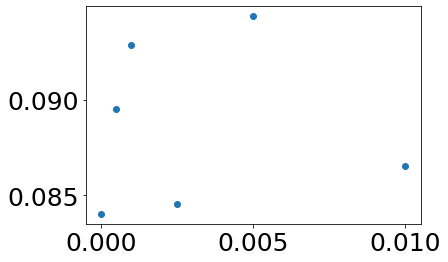

In [206]:
plt.scatter(magdisp,akmeds_mag[:6])
plt.axhline(0.04)
plt.show()
plt.scatter(magdisp,akmads_mag[:6])
plt.show()
plt.scatter(magdisp,agmeds_mag[:6])
plt.axhline(11.0)
plt.show()
plt.scatter(magdisp,agmads_mag[:6])
plt.show()

In [200]:
teffdisp= np.array([0.0,0.05,0.1,1.,5.,10.])

akmeds_teff = 999999*np.ones(len(teffdisp))
akmads_teff = 999999*np.ones(len(teffdisp))
agmeds_teff = 999999*np.ones(len(teffdisp))
agmads_teff = 999999*np.ones(len(teffdisp))

for i in tqdm_notebook(range(len(teffdisp))):
    
    spop = SynthPop(11.0,-1.5,np.array([teffdisp[i],0.01,0.01]),np.array([0.001,0.001,0.001,0.001,0.001,0.001]),
                0.04,5000,massive,nstars=275)
    spoptab = spop.make_pop()
    
    spopak = 999999.0*np.ones((len(spoptab),2))
    for j in tqdm_notebook(range(len(spoptab)),leave=False):

        abundance = np.array([[spoptab['SYNTHETIC_FEH'][j],0.,0.,0.,0.,0.,0.,0.,0.],[0.2,0.,0.,0.,0.,0.,0.,0.,0.]]).T
        phots = np.array([[spoptab['SYNTHETIC_BP'][j],spoptab['SYNTHETIC_RP'][j],spoptab['SYNTHETIC_J'][j],
                          spoptab['SYNTHETIC_H'][j],spoptab['SYNTHETIC_K'][j]],[0.025,0.025,0.025,0.025,0.025]]).T

        teffs = np.array([spoptab['SYNTHETIC_TEFF'][j],100])

        CalcAge = Aetas(teffs,abundance,phots,5000,massive)

        # Extinctions
        spopak[j,0] = CalcAge.get_ak(12.5)[0]
        spopak[j,1] = CalcAge.get_ak(12.5)[1]
        
        # Ages
        spopage[j,0] = CalcAge.get_age()[0]
        spopage[j,1] = CalcAge.get_age()[1]
    
    akmeds_teff[i] = np.median(spopak[:,0])
    akmads_teff[i] = mad(spopak[:,1])
    agmeds_teff[i] = np.median(spopage[:,0])
    agmads_teff[i] = mad(spopage[:,1])

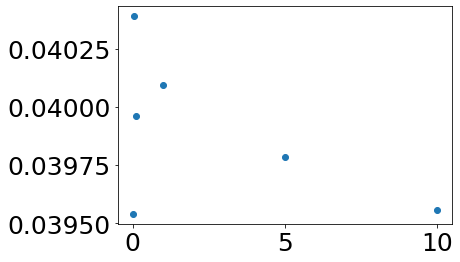

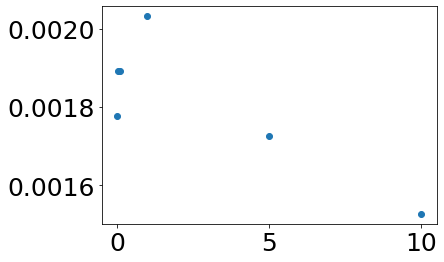

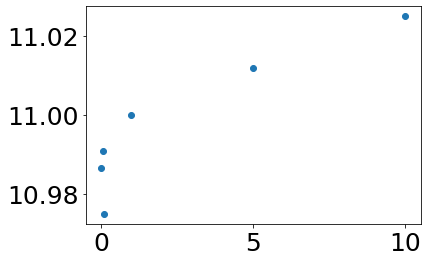

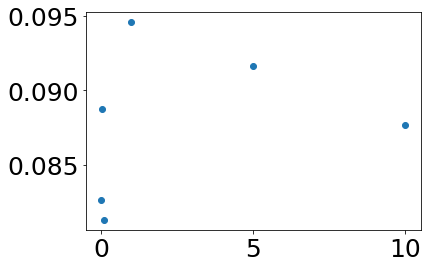

In [203]:
plt.scatter(teffdisp,akmeds_teff)
plt.axhline(0.04)
plt.show()
plt.scatter(teffdisp,akmads_teff)
plt.show()
plt.scatter(teffdisp,agmeds_teff)
plt.axhline(11.0)
plt.show()
plt.scatter(teffdisp,agmads_teff)
plt.show()

In [202]:
fehdisp= np.array([0.0,0.001,0.005,0.01,0.05,0.1])

akmeds_feh = 999999*np.ones(len(fehdisp))
akmads_feh = 999999*np.ones(len(fehdisp))
agmeds_feh = 999999*np.ones(len(fehdisp))
agmads_feh = 999999*np.ones(len(fehdisp))

for i in tqdm_notebook(range(len(fehdisp))):
    
    spop = SynthPop(11.0,-1.5,np.array([10,fehdisp[i],0.01]),np.array([0.001,0.001,0.001,0.001,0.001,0.001]),
                0.04,5000,massive,nstars=275)
    spoptab = spop.make_pop()
    
    spopak = 999999.0*np.ones((len(spoptab),2))
    for j in tqdm_notebook(range(len(spoptab)),leave=False):

        abundance = np.array([[spoptab['SYNTHETIC_FEH'][j],0.,0.,0.,0.,0.,0.,0.,0.],[0.2,0.,0.,0.,0.,0.,0.,0.,0.]]).T
        phots = np.array([[spoptab['SYNTHETIC_BP'][j],spoptab['SYNTHETIC_RP'][j],spoptab['SYNTHETIC_J'][j],
                          spoptab['SYNTHETIC_H'][j],spoptab['SYNTHETIC_K'][j]],[0.025,0.025,0.025,0.025,0.025]]).T

        teffs = np.array([spoptab['SYNTHETIC_TEFF'][j],100])

        CalcAge = Aetas(teffs,abundance,phots,5000,massive)

        # Extinctions
        spopak[j,0] = CalcAge.get_ak(12.5)[0]
        spopak[j,1] = CalcAge.get_ak(12.5)[1]
        
        # Ages
        spopage[j,0] = CalcAge.get_age()[0]
        spopage[j,1] = CalcAge.get_age()[1]
    
    akmeds_feh[i] = np.median(spopak[:,0])
    akmads_feh[i] = mad(spopak[:,1])
    agmeds_feh[i] = np.median(spopage[:,0])
    agmads_feh[i] = mad(spopage[:,1])

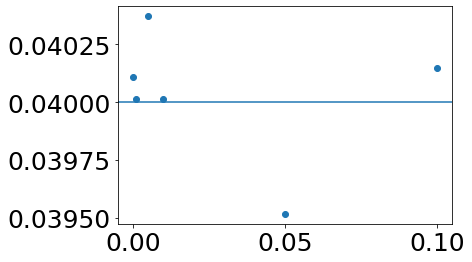

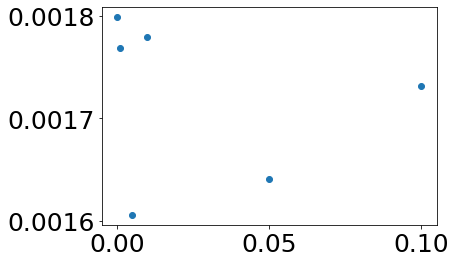

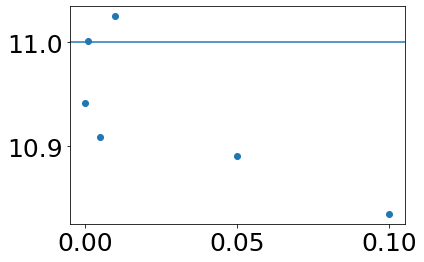

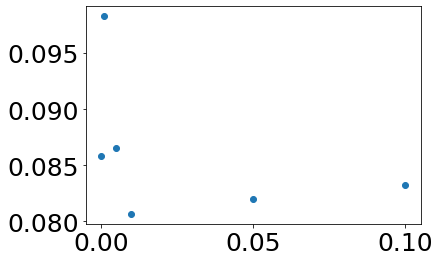

In [205]:
plt.scatter(fehdisp,akmeds_feh)
plt.axhline(0.04)
plt.show()
plt.scatter(fehdisp,akmads_feh)
plt.show()
plt.scatter(fehdisp,agmeds_feh)
plt.axhline(11.0)
plt.show()
plt.scatter(fehdisp,agmads_feh)
plt.show()